In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = '/content/drive/MyDrive/Kvasir'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image
import os
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path

In [ ]:
BATCH_SIZE = 64

train_datagen = image.ImageDataGenerator(rescale=1./255, rotation_range=40, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, fill_mode="nearest", validation_split=0.1)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [ ]:
#Defining paths
TRAIN_PATH = "/content/drive/MyDrive/Kvasir/Train"
TEST_PATH = "/content/drive/MyDrive/Kvasir/Test"

In [ ]:
train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validation_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 6480 images belonging to 8 classes.
Found 720 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [ ]:
from keras.metrics import top_k_categorical_accuracy
def top_5_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(32,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(8,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate = 1e-4),metrics=['accuracy', top_5_categorical_accuracy])

In [ ]:
#summarizing the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
model_history = model.fit(train_generator,
                            batch_size=BATCH_SIZE,
                            epochs=30,
                            validation_data=validation_generator,
                            callbacks=[tl_checkpoint_1, early_stop],
                            verbose=1)

Epoch 1/30
102/102 [==============================] - ETA: 0s - loss: 2.5613 - accuracy: 0.1534 - top_5_categorical_accuracy: 0.6660
Epoch 1: val_loss improved from inf to 1.92422, saving model to tl_model_v1.weights.best.hdf5
102/102 [==============================] - 174s 2s/step - loss: 2.5613 - accuracy: 0.1534 - top_5_categorical_accuracy: 0.6660 - val_loss: 1.9242 - val_accuracy: 0.3028 - val_top_5_categorical_accuracy: 0.8361
Epoch 2/30
102/102 [==============================] - ETA: 0s - loss: 2.3088 - accuracy: 0.2020 - top_5_categorical_accuracy: 0.7188
Epoch 2: val_loss improved from 1.92422 to 1.79054, saving model to tl_model_v1.weights.best.hdf5
102/102 [==============================] - 169s 2s/step - loss: 2.3088 - accuracy: 0.2020 - top_5_categorical_accuracy: 0.7188 - val_loss: 1.7905 - val_accuracy: 0.4056 - val_top_5_categorical_accuracy: 0.8597
Epoch 3/30
102/102 [==============================] - ETA: 0s - loss: 2.1871 - accuracy: 0.2361 - top_5_categorical_accura

In [ ]:
# Generate predictions
model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

model_preds = model.predict(test_generator)
model_pred_classes = np.argmax(model_preds, axis=1)

800/800 [==============================] - 629s 787ms/step


In [ ]:
from sklearn.metrics import accuracy_score

model_acc = accuracy_score(true_classes, model_pred_classes)
print("CNN Model's Top 1% Accuracy: {:.2f}%".format(model_acc * 100))

CNN Model's Top 1% Accuracy: 71.75%


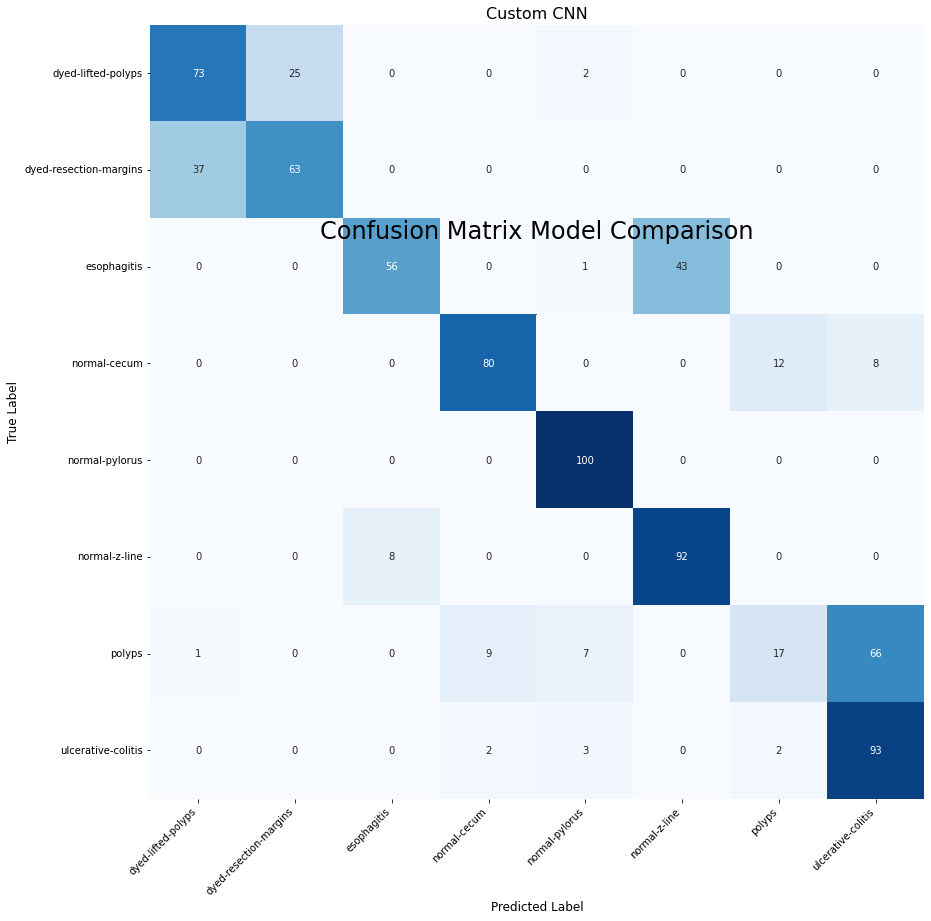

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(figsize=(20, 10))

plot_heatmap(true_classes, model_pred_classes, class_names, ax1, title="Custom CNN")    
fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()